In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# !rm -rf /content/drive/My\ Drive/darknet/data/augm
# !rm /content/drive/My\ Drive/darknet/data/ann_aug.json
# !rm /content/drive/My\ Drive/darknet/data/last_save.log

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import os
import json

root_path = "/content/drive/My Drive"
data_path = "/content/drive/My Drive/darknet/data"
module_path = os.path.abspath(os.path.join(root_path + "/code"))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataset import Dataset

ann_file = "annotations.json"
ann_aug_file = "ann_aug.json"

def plot_data(data):
    count = len(data)
    print("anns: {}".format(np.sum(data)))
    print("min: {} max: {} mean: {} stddev: {}"
        .format(data.min(), data.max(),
                data.mean(), data.std(ddof=1)))
    plt.bar(np.arange(count), data, tick_label=np.arange(count))

def show_img_hist(img_ids, excluded_scats={}):
    print("Num images {}".format(len(img_ids)))

    hist = np.zeros(len(data.scat2cat) - len(excluded_cats))

    for im_id in img_ids:
        _, cats = data.load_masks(im_id, return_mask=False)
        scats = [data.cat2scat[cat] for cat in cats]
        scats_limited = Dataset.scat_interval_limit(scats, excluded_scats)
        for scat in scats_limited:
            hist[scat] +=1    
    plot_data(hist)

def inv_class_prob(data):
    # inverse soft-max
    # normalize data
    count = data.shape[0]
    maxi = np.max(data) * np.ones(count)
    mini = np.min(data) * np.ones(count)
    norm_data = (data - mini) / (maxi - mini)

    # get probability vector

    sumexp = np.sum(np.exp(norm_data)) # exponents sum
    prob = np.exp(norm_data) / sumexp # soft-max

    # get inverse-prob vector
    maxi = 1
    inv_sum = np.sum(maxi * np.ones(count) - prob)
    invprob = (maxi * np.ones(count) - prob) / inv_sum # inverse soft-max
    return invprob

def sample_data(class_freq, stddev, num_ann, pprob=0.0, **kwargs):
    """
        sample data from a distribution of images
        exclude_init_cat - list
        exclude_aug_cat - list
        ids_include - list
        ids_exclude - list
        pprob - list
    """

    init_cats = set()
    aug_cats = set()
    img_ids = set()
    exclude_ids = set()
    skip_cats = set()
    
    if "exclude_init_cat" in kwargs.keys():
        for scat in kwargs["exclude_init_cat"]:
            init_cats |= set(data.scat2cat[scat])
    if "exclude_aug_cat" in kwargs.keys():
        for scat in kwargs["exclude_aug_cat"]:
            aug_cats |= set(data.scat2cat[scat])
    if "ids_include" in kwargs.keys():
        img_ids = set(kwargs["ids_include"])
    if "ids_exclude" in kwargs.keys():
        exclude_ids = kwargs["ids_exclude"]
    if "skip_cats" in kwargs.keys():
        skip_cats=kwargs["skip_cats"]
    
    num_cats = len(data.scat2cat) - len(skip_cats)
    num_ann_scat = np.zeros(num_cats)

    exclude_ids |= img_ids
    removed = set()

    for _id in img_ids:
        result = data.load_masks(_id, return_mask=False)
        if result is None:
            continue
        _, mask_cat = result
        mask_set = set(mask_cat.tolist())
        if init_cats & mask_set or mask_set <= skip_cats:
            removed.add(_id)
        else:
            for mcat in mask_cat:
                mcat = data.cat2scat[mcat]
                if mcat not in skip_cats:
                    mcat = Dataset.scat_interval_limit(mcat, skip_cats)[0]
                    num_ann_scat[mcat] += 1
    
    img_ids -= removed
    class_freq = np.delete(class_freq, list(skip_cats))
    class_prob = inv_class_prob(class_freq)

    while num_ann_scat.std(ddof=1) < stddev and np.sum(num_ann_scat) < num_ann:
        i = np.random.choice(num_cats, p=class_prob)
        imgs_per_cats = data.imgs_per_cats(data.scat2cat[i])
        im_id = random.choice(imgs_per_cats)
        if im_id in img_ids or im_id in exclude_ids:
            continue
        result = data.load_masks(im_id, return_mask=False)
        if result is None:
            continue
        _, mask_cat = result
        mask_set = set(mask_cat.tolist())

        if mask_set <= skip_cats:
            continue

        cprob = random.random()
        if not aug_cats & mask_set or pprob > cprob:
            for mcat in mask_cat:
                mcat = data.cat2scat[mcat]
                if mcat not in skip_cats:
                    mcat = Dataset.scat_interval_limit(mcat, skip_cats)[0]
                    num_ann_scat[mcat] += 1
            img_ids.add(im_id)
    return img_ids

In [0]:
data = Dataset(root_path + '/darknet', ann_aug_file)

scat_count = len(data.super_cat_to_cat())
scat_hist = data.count_super_cat(scat_count)

data2 = Dataset(root_path + '/darknet', ann_file)
scat_hist2 = data2.count_super_cat(scat_count)

loading annotations into memory...
Done (t=1.38s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


# Generate labels file

In [0]:
original_ids = np.arange(1500).tolist()
excluded_cats = [5, 9, 19, 22, 26, 27]
# 22 super categories remained
excluded_cats_set = set(excluded_cats)

In [0]:
train_ids = sample_data(scat_hist, 360, 20000,
                        exclude_init_cat=[4, 6],
                        pprob=0.002,
                        exclude_aug_cat=[15],
                        ids_include=original_ids,
                        skip_cats=excluded_cats_set)

test_ids = sample_data(scat_hist, 100, 2000,
                       pprob=0.055,
                       exclude_aug_cat=[15],
                       ids_exclude=train_ids,
                       skip_cats=excluded_cats_set)



In [0]:
train_idss = sample_data(scat_hist, 360, 20000,
                        exclude_init_cat=[4, 6],
                        pprob=0.002,
                        exclude_aug_cat=[15],
                        ids_include=original_ids,
                        skip_cats=excluded_cats_set)
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(np.array(list(train_idss)), test_size=0.15, random_state=0)

Num images 5070
anns: 13581.0
min: 210.0 max: 1378.0 mean: 617.3181818181819 stddev: 307.70647521911997
Num images 895
anns: 2360.0
min: 37.0 max: 222.0 mean: 107.27272727272727 stddev: 53.698613813962886


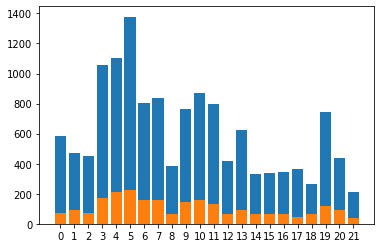

In [0]:
show_img_hist(X_train, excluded_scats=excluded_cats_set)
show_img_hist(X_test, excluded_scats=excluded_cats_set)

Num images 5760
anns: 15634.0
min: 262.0 max: 1636.0 mean: 710.6363636363636 stddev: 360.0311554580144
Num images 751
anns: 2000.0
min: 25.0 max: 217.0 mean: 90.9090909090909 stddev: 50.17294764436983


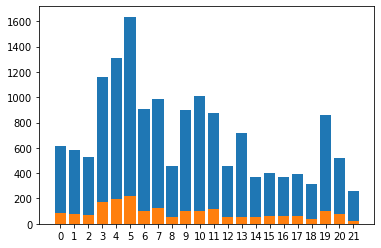

In [0]:
show_img_hist(train_ids, excluded_scats=excluded_cats_set)
show_img_hist(test_ids, excluded_scats=excluded_cats_set)

In [0]:
# train_img_paths = data.img_paths(train_ids)
# data.create_label_file(train_img_paths, excluded_cats_set)
# data.save_data(train_img_paths, "train.txt")

# test_img_paths = data.img_paths(test_ids)
# data.create_label_file(test_img_paths, excluded_cats_set)
# data.save_data(test_img_paths, "test.txt")

[(0, 1133), (1, 987), (2, 1208), (3, 3181), (4, 3162), (5, 827), (6, 3269), (7, 2243), (8, 2085), (9, 866), (10, 882), (11, 2014), (12, 2651), (13, 2164), (14, 1015), (15, 5734), (16, 1046), (17, 847), (18, 959), (19, 1290), (20, 748), (21, 715), (22, 656), (23, 1780), (24, 1891), (25, 1040), (26, 5403), (27, 3420)]
min: 656 max: 5734 mean: 1900.5714285714287 stddev: 1350.6746854147027
[(0, 62), (1, 2), (2, 7), (3, 439), (4, 289), (5, 138), (6, 273), (7, 251), (8, 192), (9, 8), (10, 6), (11, 87), (12, 273), (13, 148), (14, 27), (15, 850), (16, 72), (17, 4), (18, 37), (19, 99), (20, 29), (21, 20), (22, 7), (23, 7), (24, 161), (25, 112), (26, 517), (27, 667)]
min: 2 max: 850 mean: 170.85714285714286 stddev: 215.32743615690214


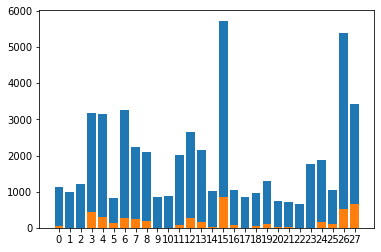

In [0]:
plot_data(scat_hist)
plot_data(scat_hist2)

In [0]:
# remove annotation lists in the annotation property
ann_path = root_path + "/darknet/data/ann_aug.json"

ds = {}
with open(ann_path, 'r') as f:
    ds = json.loads(f.read())

my_ann = []
anns = ds['annotations']
for el in anns:
    if type(el) is list:
        my_ann.extend(el)
    else:
        my_ann.append(el)

ds['annotations'] = my_ann
with open(ann_path, 'w') as f:
    ds = json.dump(ds, f, ensure_ascii=False)

In [0]:
import shutil

def split_images_per_folder():
    aug_path = data_path + "/augm"
    dirs = []
    for i in range(1,16):
        aug_dir = "augm_" + str(i)
        aug_dir_path = data_path + '/' + aug_dir
        dirs.append(aug_dir)

        if not os.path.exists(aug_dir_path):
            os.mkdir(aug_dir_path)
    dim_imgs = len(os.listdir(aug_path))
    quotient = dim_imgs // 15

    imgs_per_dir = np.ones(15) * quotient + np.array([1 if i < dim_imgs % 15 else 0 for i in range(15)])
    imgs_per_dir = imgs_per_dir.astype(np.int32)
    imgs_ids = [0]
    imgs_ids.extend(np.cumsum(imgs_per_dir).tolist())

    ann_path = root_path + "/darknet/data/ann_aug.json"

    ds = {}
    with open(ann_path, 'r') as f:
        ds = json.loads(f.read())
    img_info = ds["images"]

    for i, dir in enumerate(dirs):
        for img in range(imgs_ids[i], imgs_ids[i + 1]):
            img_id = 1500 + img
            src = data_path + '/' + img_info[img_id]["file_name"]
            dst =  dirs[i] + '/' + src.split('/')[-1]
            print("Moving {} to {}...".format(img_info[img_id]["file_name"], dst))
            img_info[img_id]["file_name"] = dst
            shutil.move(src, data_path + '/' + dst)
    
    # save_path = data_path + '/' + "test_save.json"
    ds["images"] = img_info
    with open(ann_path, 'w') as f:
        json.dump(ds, f, ensure_ascii=False)

split_images_per_folder()

# Disp image with bbox and mask


1826
626.0 2438.0 184.0 146.0
image dim: (4000, 1824, 3)
0.39364035087719296 0.62775 0.10087719298245613 0.0365
382.0 2073.0 98.0 148.0
image dim: (4000, 1824, 3)
0.2362938596491228 0.53675 0.0537280701754386 0.037
1543.0 1978.0 277.0 247.0
image dim: (4000, 1824, 3)
0.921875 0.525375 0.15186403508771928 0.06175


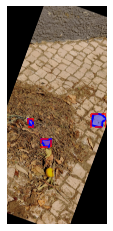

In [0]:
import cv2
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection

image_file = 'augm_1/gen_1826.jpg'
image_path = data_path + '/' + image_file

# read image into mem
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_id = data.file_ids[image_file]
print(image_id)
fig, ax = plt.subplots(1)
plt.axis('off')
plt.imshow(image)
#load anns
image_anns = data.coco.getAnnIds(image_id)
ann_sel = data.coco.loadAnns(image_anns)
for ann in ann_sel:
    bbox = ann['bbox']
    for seg in ann['segmentation']:            
        poly = Polygon(np.array(seg).reshape((int)(len(seg) / 2), 2))
        p = PatchCollection([poly], facecolor='blue', edgecolors='blue',linewidths=0, alpha=0.4)
        ax.add_collection(p)
        p = PatchCollection([poly], facecolor='none', edgecolor='blue', linewidths=2)
    ax.add_collection(p)    
    [x, y, w, h] = bbox        
    [x_c, y_c, w1, h1] = data.compute_relative_coordonates(x,y,w,h,image.shape[1],image.shape[0])
   
    rect = Rectangle((x, y), w, h, linewidth=2,edgecolor='red', facecolor='none', alpha=0.7, linestyle='--')
    ax.add_patch(rect)
plt.show()